# Data Preprocessing  


In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data.csv')
data2 = pd.read_csv('./data2.csv')
# 印出 Column Name
print(data.columns.values)
# data 的 SalePrice 取出放到y不放回
y = data.pop('SalePrice').values
X = data.iloc[:,1:]

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

### 以HouseStyle為例, 先看屬性類別有哪幾種

In [3]:
print("Nan size: %d" %X['HouseStyle'].isnull().sum(axis = 0))
X['HouseStyle'].value_counts()

Nan size: 0


1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

### 用OneHotEncoder 製造dense array取代原來的標籤類別
```python
from sklearn.preprocessing import OneHotEncoder
```
- 記得要設定 sparse=False  
- handle_unknown='ignore' 表示如果有沒出現過的類別標籤時, 會用0向量不會警告, Nan也是當作0向量  
- fit或fit_transform建立完之後, 只需要用transform()轉換即可不需重新建立  

In [4]:
from sklearn.preprocessing import OneHotEncoder
hs = X[['HouseStyle']].copy()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
hs_fit_transform = ohe.fit_transform(hs)
print(hs_fit_transform)
X2 = data2.iloc[:,1:-1]
hs2_transform=ohe.transform(X2[['HouseStyle']])

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


#### get_feature_names()可以輸出各維度名稱  
#### inverse_transform()可以反轉換


In [5]:
features_name = one.get_feature_names()
# 可以用get_feature_names加上條件判斷式輸出
features_name[hs_fit_transform[0]==1]
#也可以直接反轉換
one.inverse_transform([hs_fit_transform[0]])
#one.inverse_transform([hs2[0]])

array([['2Story']], dtype=object)

## Must impute missing values  
- 對於fit/fit_transform 後的資料, 只要有設定handle_unknown='ignore'  
缺失值會用0向量表示
- 但fit/fit_transform的資料如果有缺失值, 就會有問題  
這時候要用SimpleImputer先把資料補起來  

```python
from sklearn.impute import SimpleImputer
```  

- strategy='constant', fill_value='MISSING' 表示遇到缺失值用定值'MISSING'來補  


In [6]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='constant', fill_value='MISSING')
hs2 = X2['HouseStyle'].copy()

# numpy計算
def count_classes(sets):
    count_dict = {}
    for row in sets:
        if row not in count_dict:
            count_dict[row] = 0
        count_dict[row] += 1
    print('size: %d' % sum(count_dict.values()))
    print(count_dict)
    
hs2.iloc[0] = np.nan
hs2_imputed = si.fit_transform([hs2])
count_classes(hs2_imputed[0])

size: 1459
{'MISSING': 1, '1Story': 744, '2Story': 427, 'SLvl': 63, '1.5Fin': 160, 'SFoyer': 46, '2.5Unf': 13, '1.5Unf': 5}


### 用Pipe結合encoder跟imputer  
```python
from sklearn.pipeline import Pipeline
```  
- 先宣告要做的各個step  
- 再用Pipeline()串起來  
- 使用fit_transform()對資料執行steps中的使用fit_transform  
- 之後用transform()可重複對其他資料做transform   
- named_steps['名稱']可以取出step

In [7]:
from sklearn.pipeline import Pipeline
imputer_step = ('si_step',SimpleImputer(strategy='constant', fill_value='MISSING'))
encoder_step = ('onehot_step', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe = Pipeline([imputer_step, encoder_step])

hs = X[['HouseStyle']].copy()
hs.iloc[0] = np.nan

hs2 = X2[['HouseStyle']].copy()
hs2.iloc[0] = np.nan

hs_transformed = pipe.fit_transform(hs)
hs2_transformed = pipe.transform(hs2)

ohe = pipe.named_steps['onehot_step']

ohe.inverse_transform([hs_transformed[0]])

array([['MISSING']], dtype=object)

### Transforming Multiple Columns  
可以同時多個column一起轉換

In [8]:
hsr = X[['HouseStyle','RoofMatl']].copy()

hsr.iloc[0,0] = np.nan
hsr.iloc[1,1] = np.nan

imputer_step = ('si_step',SimpleImputer(strategy='constant', fill_value='MISSING'))
encoder_step = ('onehot_step', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe = Pipeline([imputer_step, encoder_step])

hsr_transformed = pipe.fit_transform(hsr)
ohe = pipe.named_steps['onehot_step']

print(ohe.get_feature_names())

print(hsr_transformed[:5])

ohe.inverse_transform([hsr_transformed[0]])

['x0_1.5Fin' 'x0_1.5Unf' 'x0_1Story' 'x0_2.5Fin' 'x0_2.5Unf' 'x0_2Story'
 'x0_MISSING' 'x0_SFoyer' 'x0_SLvl' 'x1_ClyTile' 'x1_CompShg' 'x1_MISSING'
 'x1_Membran' 'x1_Metal' 'x1_Roll' 'x1_Tar&Grv' 'x1_WdShake' 'x1_WdShngl']
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


array([['MISSING', 'CompShg']], dtype=object)

### ColumnTransformer  
```python
from sklearn.compose import ColumnTransformer
```  
對每個column做pipe

In [29]:
from sklearn.compose import ColumnTransformer

imputer_step = ('ct_si_step', SimpleImputer(strategy='constant', fill_value='MISSING'))
encoder_step = ('ct_onehot_step', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe = Pipeline([imputer_step,encoder_step])
ct_transformers = [('ct_transformers', pipe, ['HouseStyle','RoofMatl'])]
ct = ColumnTransformer(transformers=ct_transformers)
# 轉換['HouseStyle','RoofMatl']這兩個維度
X_ct = ct.fit_transform(X)
print(X_ct.shape)
ct_pipe = ct.named_transformers_['ct_transformers']
ct_ohe = ct_pipe.named_steps['ct_onehot_step']

ct_ohe.inverse_transform([X_ct[0]])

(1460, 16)


array([['2Story', 'CompShg']], dtype=object)

### Transforming the numeric columns  
- dtypes可以得到是int64,object,float64...  
- kind可以轉成'i','O','f'....  
- columns.values取出行名稱

In [54]:
#print(X.dtypes.head())
kinds = np.array([dt.kind for dt in X.dtypes])
#print(kinds)
is_num = kinds != 'O'
#print(is_num)
numeric_column_name = X.columns.values[is_num]
category_column_name = X.columns.values[~is_num]
print('NUM:')
print(numeric_column_name)
print('CATEGORY:')
print(category_column_name)

NUM:
['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold']
CATEGORY:
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeatu

### 同時加入處理數值跟類別到 ColumnTransformer
可以使用StandardScaler標準化數值
```python
from sklearn.preprocessing import StandardScaler
```

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

category_imputer_step = ('category_si_step', SimpleImputer(strategy='constant', fill_value='MISSING'))
category_encoder_step = ('category_onehot_step', OneHotEncoder(sparse=False, handle_unknown='ignore'))
category_pipe = Pipeline([category_imputer_step,category_encoder_step])

num_imputer_step = ('num_si_step', SimpleImputer(strategy='median'))
num_standatd_step = ('num_ss_step', StandardScaler())
num_pipe = Pipeline([num_imputer_step,num_standatd_step])

ct_transformers = [('num_ct_transformers', num_pipe, numeric_column_name),
                   ('category_ct_transformers', category_pipe, category_column_name)
                  ]
ct = ColumnTransformer(transformers=ct_transformers)
X_ct = ct.fit_transform(X)
print(X_ct.shape)

(1460, 304)


### ML Pipe
將ML做成pipe

In [104]:
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error

ml_pipe = Pipeline([('transform', ct), ('ridge', Ridge())])
ml_pipe.fit(X, y)
prediction = ml_pipe.predict(X)
rms_error = np.sqrt(sum([(prediction[i]-y[i])**2 for i in range(len(y))])/float(len(y)))
print(rms_error)
print(np.sqrt(mean_squared_error(y_pred=prediction,y_true=y)))


22171.961914674655
22171.961914674677


### 畫出圖形

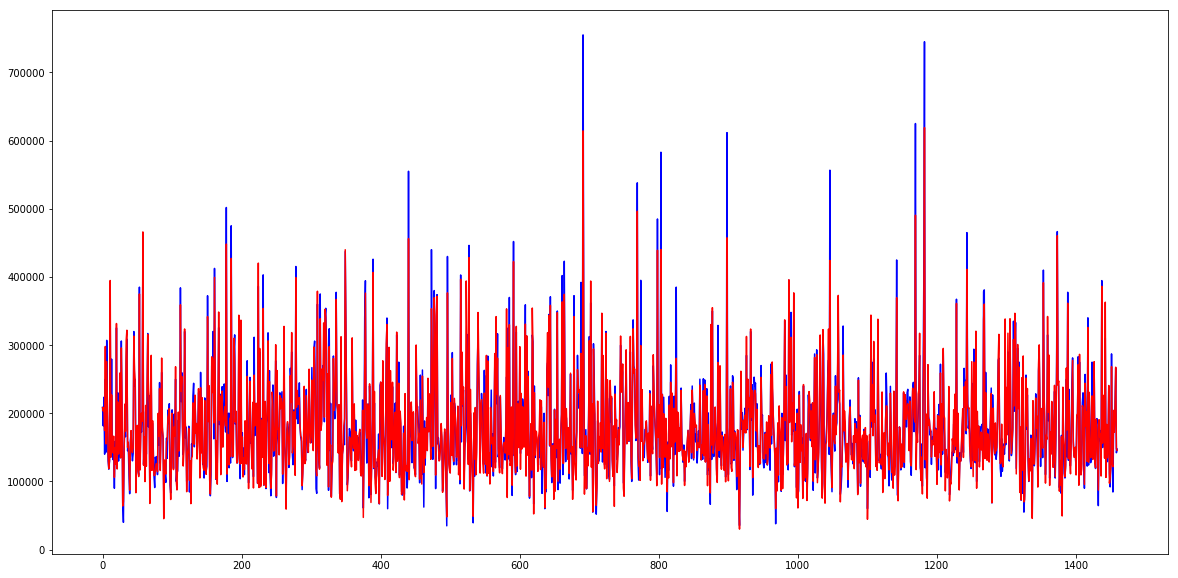

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
x = np.arange(len(y))
plt.plot(x,y,c='b')
plt.plot(x,prediction,c='r')
plt.show()

## K fold

In [131]:
from sklearn.model_selection import KFold, cross_val_score
ml_pipe = Pipeline([('transform', ct), ('ridge', Ridge())])
kf = KFold(n_splits=5, shuffle=True, random_state=123)
rms_kfold = []
for train_index, validation_index in kf.split(X):
    # X is pandas type
    X_train, X_validation =  X.iloc[train_index],  X.iloc[validation_index]
    # y is ndarray type
    y_train, y_validation = y[train_index], y[validation_index]
    ml_pipe.fit(X_train, y_train)
    prediction = ml_pipe.predict(X_validation)
    rms_kfold.append(np.sqrt(mean_squared_error(y_pred=prediction,y_true=y_validation)))

np.mean(rms_kfold)

33579.13399029073

### Grid Search
- param_grid:  
  * ml_pipe: 'ml_transform'  
  * ct_transformers: 'num_ct_transformers'  
  * num_imputer_step: 'num_si_step'  
  * SimpleImputer(strategy='median')
  * 合起來就是ml_transform__num_ct_transformers__num_si_step__strategy
  
estimator需要有score函數, scoring會利用該函數驗證  
  

In [143]:
from sklearn.model_selection import GridSearchCV
ml_pipe = Pipeline([('ml_transform', ct), ('ridge', Ridge())])
param_grid = {
    'ml_transform__num_ct_transformers__num_si_step__strategy': ['mean', 'median'],
    'ridge__alpha': [.001, 0.1, 1.0, 5, 10, 50, 100, 1000],
    }
kf = KFold(n_splits=5, shuffle=True, random_state=123)
# estimator need provide a score function
gsearch = GridSearchCV(estimator=ml_pipe, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_


({'ml_transform__num_ct_transformers__num_si_step__strategy': 'median',
  'ridge__alpha': 10},
 -1142405513.1486785)

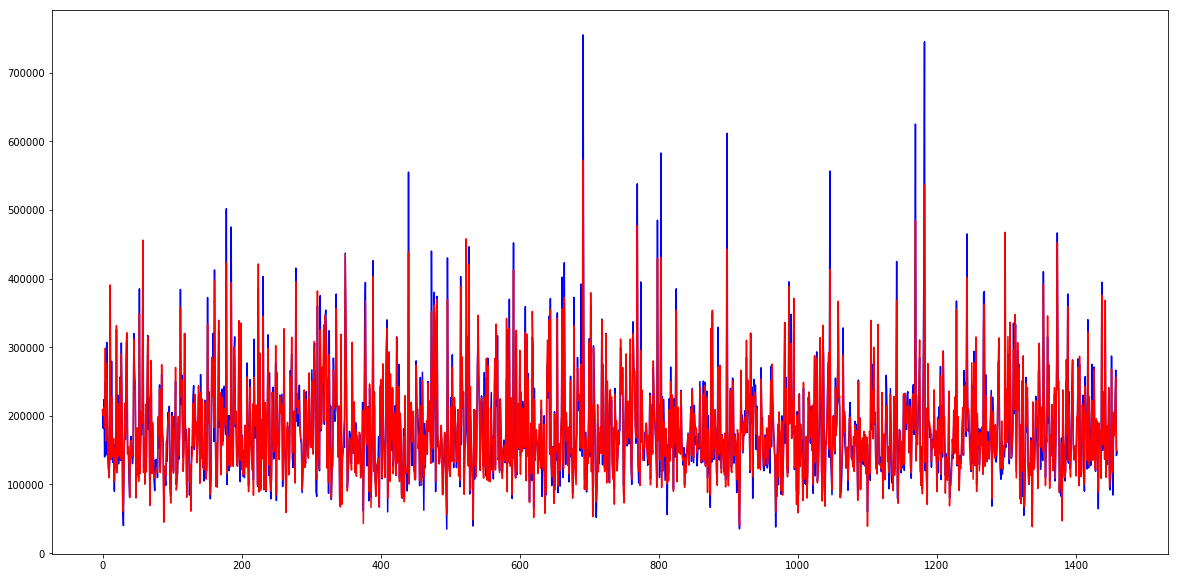

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [153]:

category_imputer_step = ('category_si_step', SimpleImputer(strategy='constant', fill_value='MISSING'))
category_encoder_step = ('category_onehot_step', OneHotEncoder(sparse=False, handle_unknown='ignore'))
category_pipe = Pipeline([category_imputer_step,category_encoder_step])

num_imputer_step = ('num_si_step', SimpleImputer(strategy='median'))
num_standatd_step = ('num_ss_step', StandardScaler())
num_pipe = Pipeline([num_imputer_step,num_standatd_step])

ct_transformers = [('num_ct_transformers', num_pipe, numeric_column_name),
                   ('category_ct_transformers', category_pipe, category_column_name)
                  ]
ct = ColumnTransformer(transformers=ct_transformers)

best_ml_pipe = Pipeline([('transform', ct), ('ridge', Ridge(alpha=10))])
best_ml_pipe.fit(X, y)
prediction = best_ml_pipe.predict(X)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
x = np.arange(len(y))
plt.plot(x,y,c='b')
plt.plot(x,prediction,c='r')
plt.show()

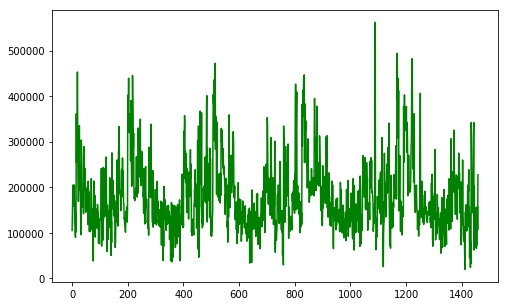

In [174]:
data2 = pd.read_csv('./data2.csv')
data2.head()

X2 = data2.iloc[:,1:]
prediction = best_ml_pipe.predict(X2)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))

x = np.arange(len(X2))
plt.plot(x,prediction,c='g')
plt.show()
# Output Result
result_pd = pd.DataFrame(prediction,columns=['SalePrice'])
result_pd.index += 1461
result_pd.head()
result_pd.to_csv('result.csv',index=True, index_label='Id')

畫盒型圖

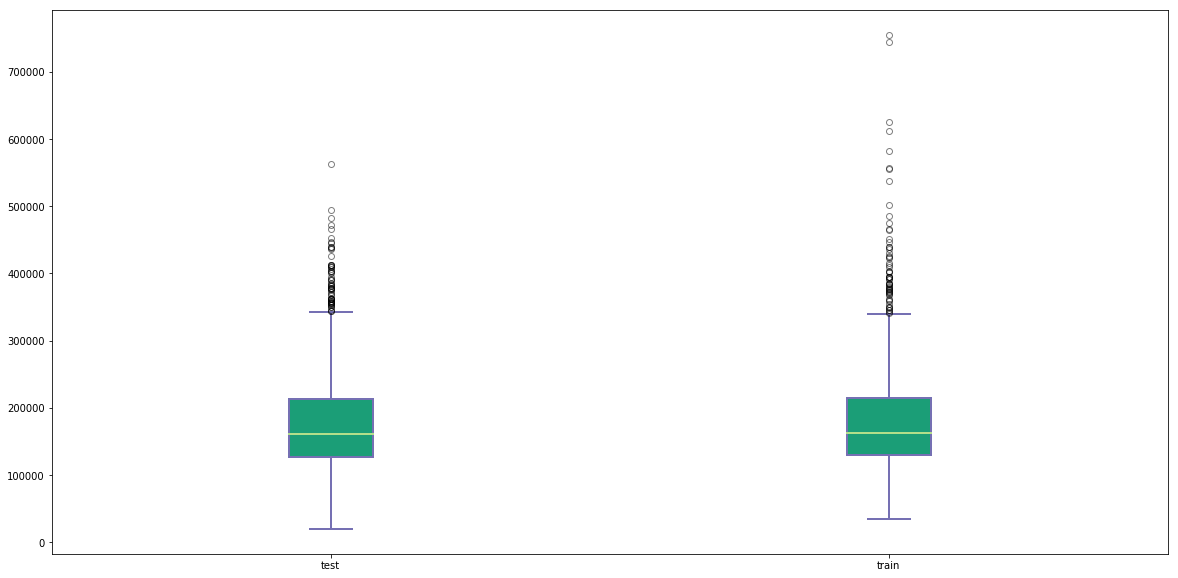

In [195]:
plt.figure(figsize=(20,10))
bp = plt.boxplot([prediction,y],patch_artist=True,  labels=('test','train'))
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
# 垂直線部分
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
# Q3,Q1上下四分位數    
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## 畫出中位數
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)   
## change the style of fliers and their fill
# outlier 離群值
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.show()